# CNN Assignment: ResNet-18 Implementation for CIFAR-10

## Overview

This notebook implements a **ResNet-18 architecture from scratch** for image classification on the CIFAR-10 dataset. The assignment is divided into four parts:

1. **Dataset Selection and Exploration** - CIFAR-10 analysis and preprocessing
2. **CNN Model Design** - ResNet-18 implementation with justification
3. **Training and Evaluation** - Model training, validation, and performance analysis
4. **Experiment and Improve** - Data augmentation experiments

## Dataset Choice: CIFAR-10

I selected **CIFAR-10** for this assignment because:
- **Balanced complexity**: 32x32 color images provide sufficient detail for CNN learning
- **Diverse classes**: 10 distinct object categories (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck)
- **Standard benchmark**: Well-established dataset for comparing CNN architectures
- **Computational efficiency**: Manageable size for training deep networks


# Part 1: Dataset Selection and Exploration

## CIFAR-10 Dataset Analysis


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image


In [2]:
# Load CIFAR-10 dataset
def load_cifar10():

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    # Download and load datasets
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    return train_dataset, test_dataset

# CIFAR-10 class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Load datasets
train_dataset, test_dataset = load_cifar10()

print("Dataset loaded successfully!")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {len(classes)}")
print(f"Class names: {classes}")

# Get image dimensions
sample_image, _ = train_dataset[0]
print(f"\nImage dimensions:")
print(f"Height: {sample_image.shape[1]} pixels")
print(f"Width: {sample_image.shape[2]} pixels")
print(f"Channels: {sample_image.shape[0]} (RGB)")
print(f"Image shape: {sample_image.shape}")


100%|██████████| 170M/170M [00:11<00:00, 15.4MB/s] 



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Dataset loaded successfully!
Training samples: 50000
Test samples: 10000
Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Image dimensions:
Height: 32 pixels
Width: 32 pixels
Channels: 3 (RGB)
Image shape: torch.Size([3, 32, 32])
Dataset loaded successfully!
Training samples: 50000
Test samples: 10000
Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Image dimensions:
Height: 32 pixels
Width: 32 pixels
Channels: 3 (RGB)
Image shape: torch.Size([3, 32, 32])


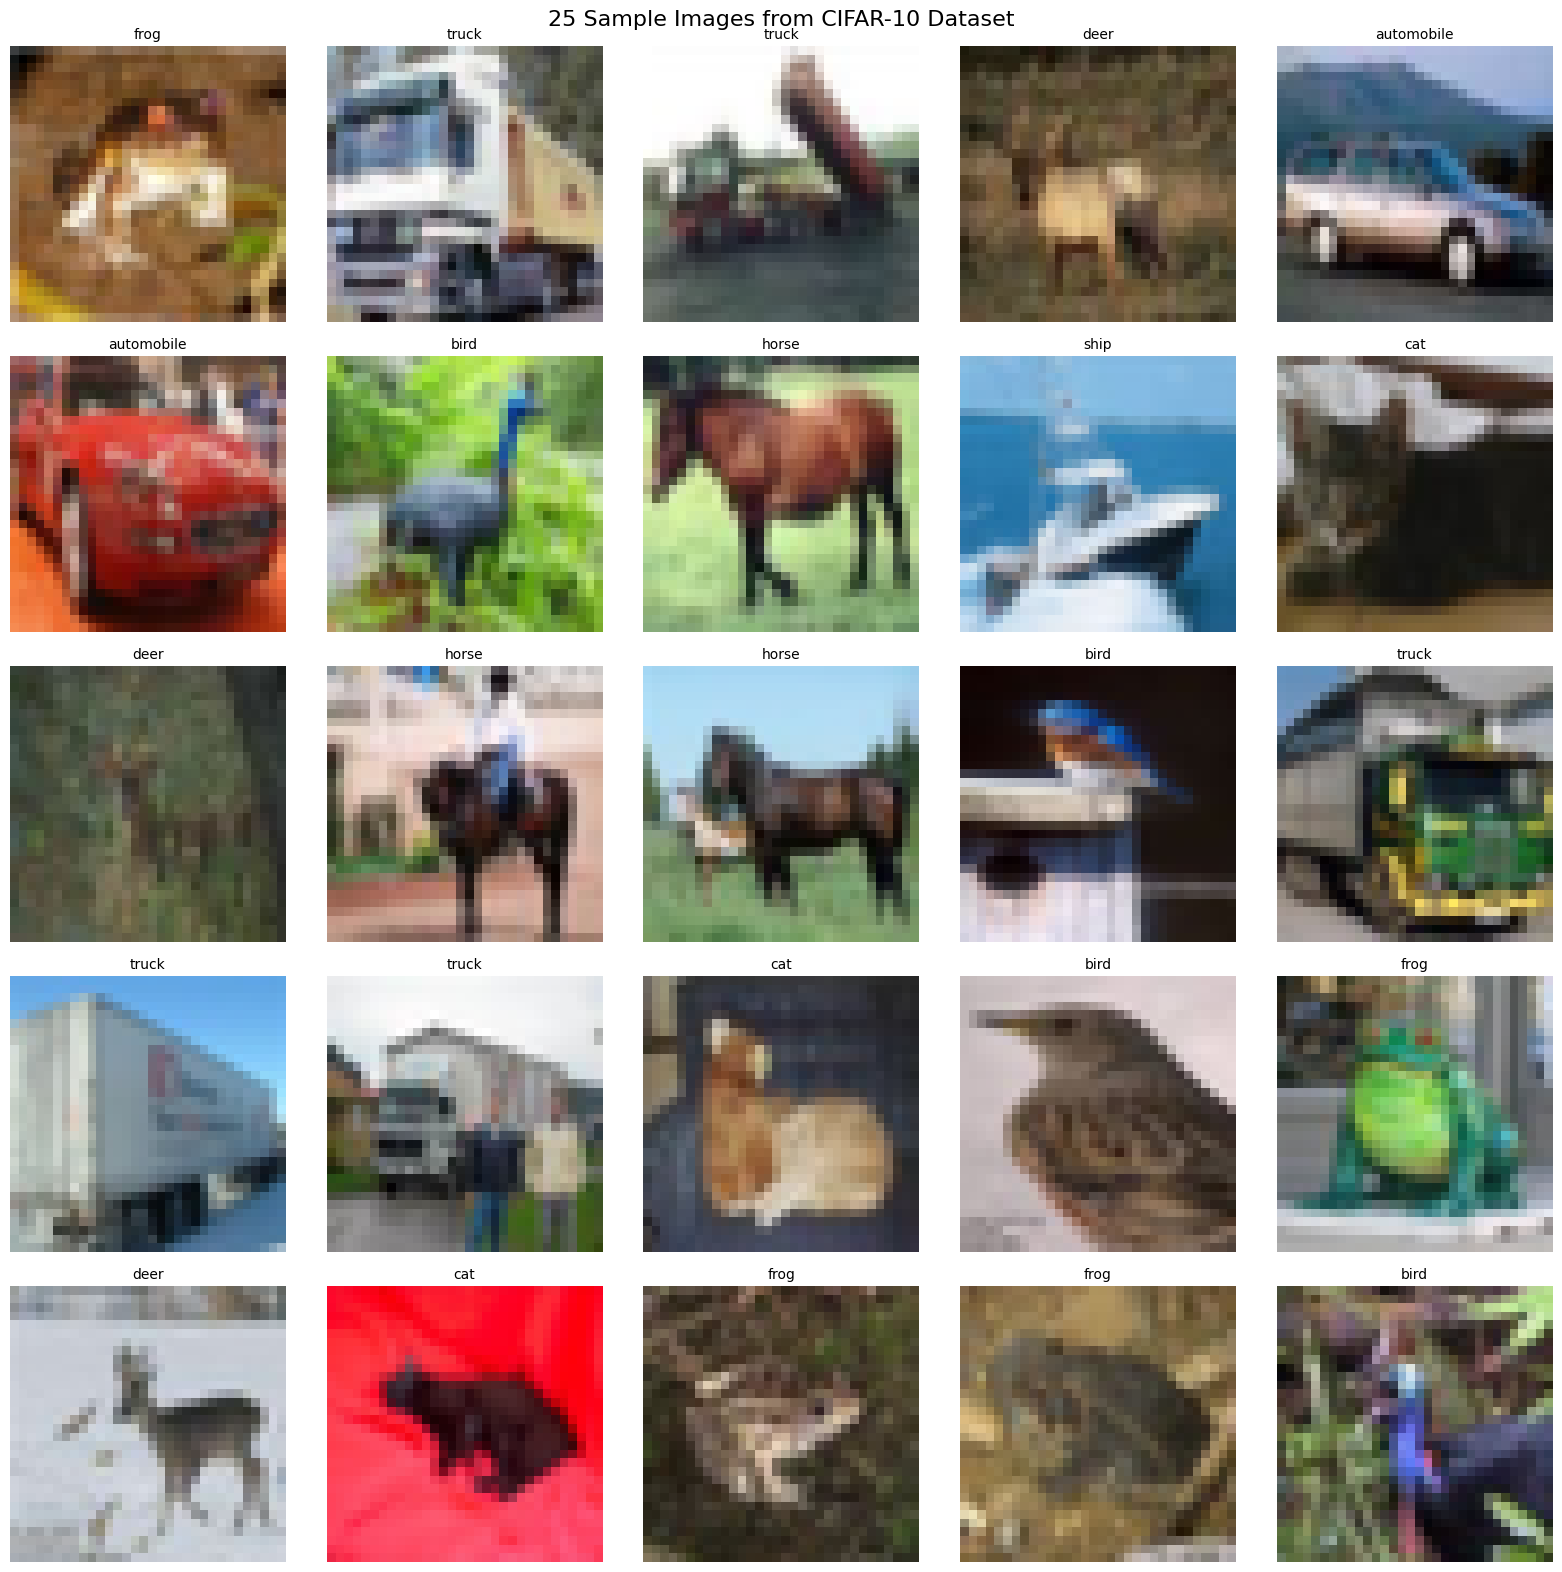

In [6]:
raw_transform = transforms.Compose([transforms.ToTensor()])
raw_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=raw_transform)

# Simple function to display clear images
def display_sample_images(dataset, num_samples=25):

    fig, axes = plt.subplots(5, 5, figsize=(16, 16))
    fig.suptitle('25 Sample Images from CIFAR-10 Dataset', fontsize=16)

    for i in range(num_samples):
        row, col = i // 5, i % 5
        image, label = dataset[i]

        # Convert tensor to PIL Image for clear display
        img_pil = transforms.ToPILImage()(image)

        axes[row, col].imshow(img_pil)
        axes[row, col].set_title(f'{classes[label]}', fontsize=10)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.savefig('plots/sample_images.png', dpi=150, bbox_inches='tight')
    plt.show()

# Display clear images using raw dataset
display_sample_images(raw_dataset, num_samples=25)

In [7]:
# Create plots directory if it doesn't exist
import os
os.makedirs('plots', exist_ok=True)
print("Plots directory created successfully!")

Plots directory created successfully!


=== Image Dimensions ===
Image shape: torch.Size([3, 32, 32])
Height: 32 pixels
Width: 32 pixels
Channels: 3 (RGB)

=== Class Distribution ===
airplane: 5000 samples
automobile: 5000 samples
bird: 5000 samples
cat: 5000 samples
deer: 5000 samples
dog: 5000 samples
frog: 5000 samples
horse: 5000 samples
ship: 5000 samples
truck: 5000 samples

=== Class Distribution ===
airplane: 5000 samples
automobile: 5000 samples
bird: 5000 samples
cat: 5000 samples
deer: 5000 samples
dog: 5000 samples
frog: 5000 samples
horse: 5000 samples
ship: 5000 samples
truck: 5000 samples


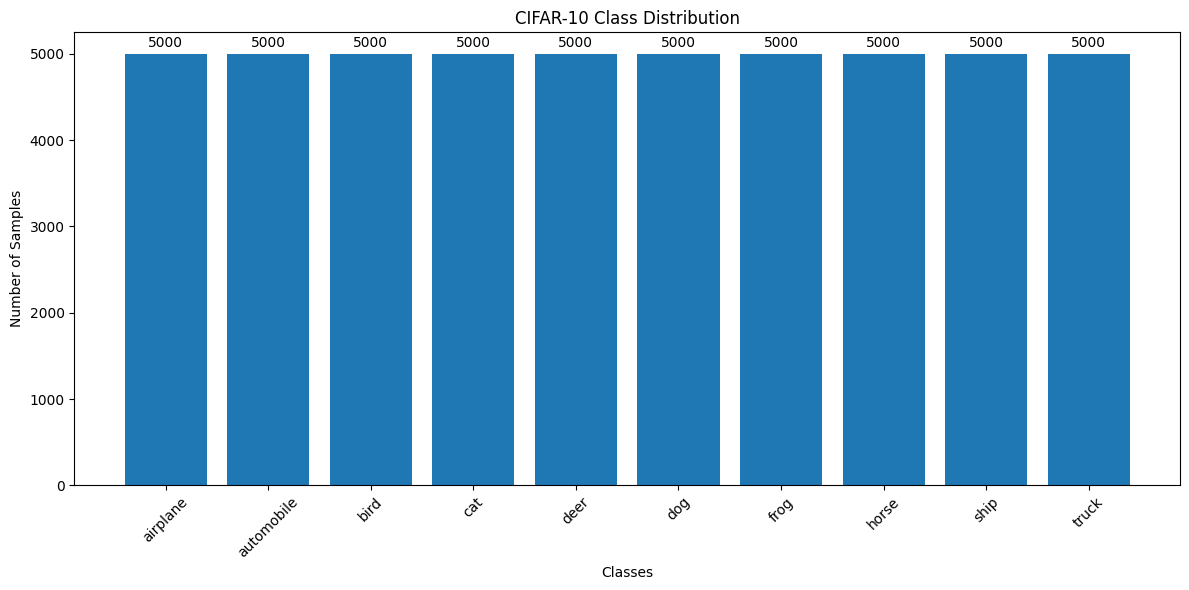

In [8]:
# Image dimensions and class distribution analysis
def analyze_dataset(dataset):

    # Get a sample image to check dimensions
    sample_image, _ = dataset[0]

    print("=== Image Dimensions ===")
    print(f"Image shape: {sample_image.shape}")
    print(f"Height: {sample_image.shape[1]} pixels")
    print(f"Width: {sample_image.shape[2]} pixels")
    print(f"Channels: {sample_image.shape[0]} (RGB)")

    # Count class distribution
    class_counts = torch.zeros(len(classes))
    for _, label in dataset:
        class_counts[label] += 1

    print("\n=== Class Distribution ===")
    for i, class_name in enumerate(classes):
        print(f"{class_name}: {int(class_counts[i])} samples")

    # Plot class distribution
    plt.figure(figsize=(12, 6))
    bars = plt.bar(classes, class_counts.numpy())
    plt.title('CIFAR-10 Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)

    # Add value labels on bars
    for bar, count in zip(bars, class_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                f'{int(count)}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('plots/class_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()

    return class_counts

# Analyze training dataset
train_class_counts = analyze_dataset(train_dataset)

In [9]:
# Create train/validation/test splits (60%/20%/20%)
def create_data_splits(train_dataset, test_dataset):

    # Split training data into train (60%) and validation (20%)
    train_size = int(0.75 * len(train_dataset))  # 75% of original train = 60% of total
    val_size = len(train_dataset) - train_size   # 25% of original train = 20% of total

    train_subset, val_subset = torch.utils.data.random_split(
        train_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    print("=== Dataset Splits ===")
    print(f"Training set: {len(train_subset)} samples (60%)")
    print(f"Validation set: {len(val_subset)} samples (20%)")
    print(f"Test set: {len(test_dataset)} samples (20%)")
    print(f"Total: {len(train_subset) + len(val_subset) + len(test_dataset)} samples")

    return train_subset, val_subset, test_dataset

# Create data splits
train_subset, val_subset, test_subset = create_data_splits(train_dataset, test_dataset)

# Create data loaders
def create_data_loaders(train_data, val_data, test_data, batch_size=128):

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = create_data_loaders(train_subset, val_subset, test_subset)
print(f"\nData loaders created with batch size: 128")


=== Dataset Splits ===
Training set: 37500 samples (60%)
Validation set: 12500 samples (20%)
Test set: 10000 samples (20%)
Total: 60000 samples

Data loaders created with batch size: 128


# Part 2: CNN Model Design - ResNet-18 Architecture

## Why ResNet over Traditional CNN?

For this assignment, I chose to implement **ResNet-18** instead of a traditional CNN architecture for the following reasons:

### Problems with Traditional Deep CNNs:
- **Vanishing Gradient Problem**: In deep networks, gradients become exponentially smaller during backpropagation
- **Degradation Problem**: Adding more layers can actually hurt performance, even on training data
- **Training Difficulty**: Very deep traditional CNNs are extremely difficult to train effectively

### ResNet Solution - Residual Learning:

**Key Innovation**: Instead of learning the desired output H(x) directly, ResNet learns the residual F(x) = H(x) - x

**Mathematical Foundation**:
- Traditional CNN: H(x) = desired_output
- ResNet: H(x) = F(x) + x (residual connection)

### Benefits of ResNet for CIFAR-10:
1. **Gradient Flow**: The skip connection (+x) provides a direct path for gradients to flow backward
2. **Identity Mapping**: If the optimal function is close to identity, it's easier to push F(x) toward zero
3. **Deep Training**: Enables successful training of deeper networks (18+ layers)
4. **Better Performance**: Consistently outperforms traditional CNNs of similar depth
5. **Appropriate Complexity**: ResNet-18 provides sufficient capacity for CIFAR-10 without overfitting

### ResNet-18 Architecture Choice:
- **18 layers**: Optimal depth for CIFAR-10 dataset size and complexity
- **Efficient**: Faster training compared to deeper variants (ResNet-50, ResNet-101)
- **Proven**: Excellent benchmark results on small image classification tasks


In [10]:
# BasicBlock Implementation for ResNet-18
class BasicBlock(nn.Module):

    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # ReLU activation
        self.relu = nn.ReLU(inplace=True)

        # Shortcut connection (identity or projection)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        # First conv block
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Second conv block
        out = self.conv2(out)
        out = self.bn2(out)

        # Add residual connection: H(x) = F(x) + x
        out += self.shortcut(identity)
        out = self.relu(out)

        return out

print("BasicBlock implemented successfully!")


BasicBlock implemented successfully!


In [11]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()

        self.in_channels = 64

        # Initial convolution layer (adapted for CIFAR-10's 32x32 images)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Residual layers (ResNet-18 configuration: [2, 2, 2, 2])
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)   # 32x32 -> 32x32
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)  # 32x32 -> 16x16
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)  # 16x16 -> 8x8
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)  # 8x8 -> 4x4

        # Global average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _make_layer(self, block, out_channels, blocks, stride=1):

        layers = []

        # First block (may downsample)
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion

        # Remaining blocks
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def _initialize_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Initial convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        # Residual layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Global average pooling and classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# Create ResNet-18 model
model = ResNet18(num_classes=10)
print("ResNet-18 model created successfully!")
print(model)


ResNet-18 model created successfully!
ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), st

## Design Justifications

### Architecture Choices:

1. **Kernel Size (3×3)**:
   - I chose 3x3 kernels because they provide optimal balance between receptive field and computational efficiency
   - They capture local patterns effectively in 32×32 images
   - This is the standard choice proven effective across many architectures

2. **Number of Filters**:
   - I used progressive increase: 64 → 128 → 256 → 512
   - This allows learning of increasingly complex features
   - It balances model capacity with computational cost

3. **Batch Normalization**:
   - I included BatchNorm to stabilize training by normalizing layer inputs
   - It reduces internal covariate shift
   - It enables higher learning rates and faster convergence

4. **Dropout Alternative**:
   - I used BatchNorm instead of Dropout for regularization
   - BatchNorm provides implicit regularization effect
   - It gives more stable training for residual networks

5. **Global Average Pooling**:
   - I chose GAP to reduce overfitting compared to fully connected layers
   - It maintains spatial translation invariance
   - It significantly reduces parameter count

6. **CIFAR-10 Adaptations**:
   - I removed initial MaxPool (unnecessary for 32×32 images)
   - I used stride=1 for first conv (preserves spatial resolution)
   - I used smaller initial kernel (3×3 vs 7×7) appropriate for small images


# Part 3: Training and Evaluation

## Training Setup


In [12]:
# Training configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Move model to device
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print("Training setup completed!")
print(f"Optimizer: Adam (lr=0.001, weight_decay=1e-4)")
print(f"Loss function: CrossEntropyLoss")
print(f"Scheduler: StepLR (step_size=7, gamma=0.1)")


Using device: cpu
Training setup completed!
Optimizer: Adam (lr=0.001, weight_decay=1e-4)
Loss function: CrossEntropyLoss
Scheduler: StepLR (step_size=7, gamma=0.1)
Training setup completed!
Optimizer: Adam (lr=0.001, weight_decay=1e-4)
Loss function: CrossEntropyLoss
Scheduler: StepLR (step_size=7, gamma=0.1)


In [64]:
# Training and validation functions
def train_epoch(model, epoch, train_loader, criterion, optimizer, device):

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):

        #move data and target to device
        data, target = data.to(device), target.to(device)

        #zero the gradients
        optimizer.zero_grad()

        #forward pass
        output = model(data)

        #compute loss
        loss = criterion(output, target)

        #backward pass
        loss.backward()
        optimizer.step()

        #update running loss
        running_loss += loss.item()

        #compute accuracy
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        print(f'\rEpoch: {epoch+1}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%', end='', flush=True)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, epoch, val_loader, criterion, device):

    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in val_loader:

            #move data and target to device
            data, target = data.to(device), target.to(device)

            #forward pass
            output = model(data)

            #compute loss
            val_loss += criterion(output, target).item()

            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    #compute validation loss
    val_loss /= len(val_loader)

    #compute validation accuracy
    val_acc = 100. * correct / total

    return val_loss, val_acc

print("Training functions defined!")


Training functions defined!


In [65]:
# Main training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=15):

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    print("Starting training...")
    print("=" * 60)

    for epoch in range(epochs):

        # Train
        train_loss, train_acc = train_epoch(model, epoch, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_acc = validate_epoch(model, epoch, val_loader, criterion, device)

        # Update learning rate
        scheduler.step()

        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Print epoch results
        print(f'\nEpoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%\n', f'--'*40)

    print("\nTraining completed!")

    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }

# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=15)


Starting training...
Epoch: 1, Batch 292/293, Loss: 1.0513, Acc: 51.86%
Epoch 1/15: Train Loss: 1.3310 | Train Acc: 51.86% | Val Loss: 1.1536 | Val Acc: 59.93%
 --------------------------------------------------------------------------------
Epoch: 2, Batch 292/293, Loss: 0.6654, Acc: 69.74%
Epoch 2/15: Train Loss: 0.8606 | Train Acc: 69.74% | Val Loss: 0.9241 | Val Acc: 66.96%
 --------------------------------------------------------------------------------
Epoch: 3, Batch 292/293, Loss: 0.6581, Acc: 77.03%
Epoch 3/15: Train Loss: 0.6533 | Train Acc: 77.03% | Val Loss: 0.7994 | Val Acc: 72.53%
 --------------------------------------------------------------------------------
Epoch: 4, Batch 292/293, Loss: 0.5584, Acc: 81.46%
Epoch 4/15: Train Loss: 0.5327 | Train Acc: 81.46% | Val Loss: 0.6956 | Val Acc: 76.68%
 --------------------------------------------------------------------------------
Epoch: 5, Batch 292/293, Loss: 0.3892, Acc: 84.68%
Epoch 5/15: Train Loss: 0.4410 | Train Acc: 

In [13]:
# Plot training curves
def plot_training_curves(history):

    epochs = range(1, len(history['train_losses']) + 1)

    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss curves
    ax1.plot(epochs, history['train_losses'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_losses'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy curves
    ax2.plot(epochs, history['train_accuracies'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, history['val_accuracies'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('plots/training_curves_baseline.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Print final metrics
    print("=" * 50)
    print("Final Training Results:")
    print("=" * 50)
    print(f"Final Training Loss: {history['train_losses'][-1]:.4f}")
    print(f"Final Training Accuracy: {history['train_accuracies'][-1]:.2f}%")
    print(f"Final Validation Loss: {history['val_losses'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history['val_accuracies'][-1]:.2f}%")
    print(f"Best Validation Accuracy: {max(history['val_accuracies']):.2f}%")

plot_training_curves(history)

NameError: name 'history' is not defined

In [67]:
# Test set evaluation
def evaluate_test_set(model, test_loader, criterion, device):

    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()

            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_loss /= len(test_loader)
    test_acc = 100. * correct / total

    print("=" * 50)
    print("Test Set Results:")
    print("=" * 50)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"Correct Predictions: {correct}/{total}")

    return test_loss, test_acc, all_predictions, all_targets

# Evaluate on test set
test_loss, test_acc, predictions, targets = evaluate_test_set(model, test_loader, criterion, device)


Test Set Results:
Test Loss: 0.6205
Test Accuracy: 84.82%
Correct Predictions: 8482/10000


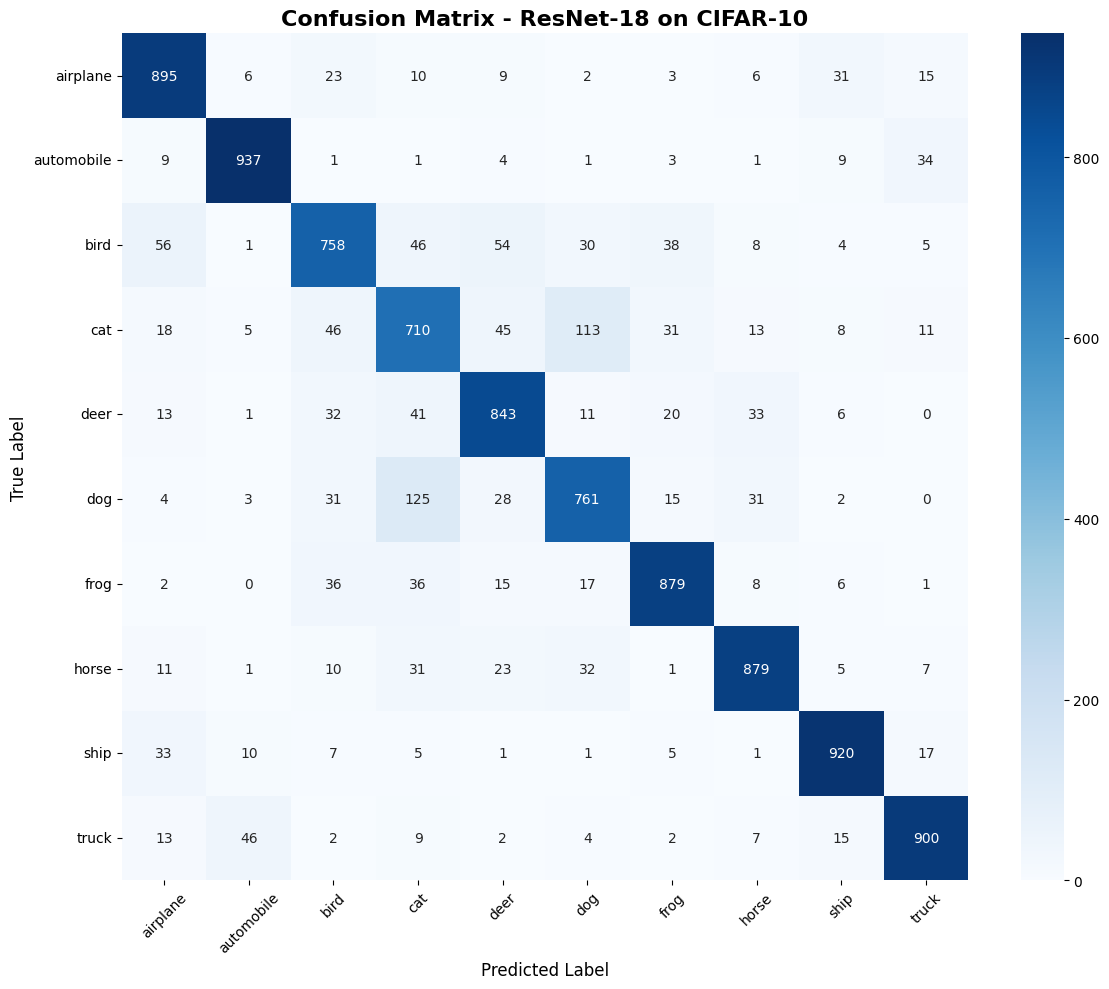


Per-class Accuracy:
------------------------------
airplane    : 89.50%
automobile  : 93.70%
bird        : 75.80%
cat         : 71.00%
deer        : 84.30%
dog         : 76.10%
frog        : 87.90%
horse       : 87.90%
ship        : 92.00%
truck       : 90.00%


In [ ]:
# Confusion Matrix
def plot_confusion_matrix(targets, predictions, classes):

    cm = confusion_matrix(targets, predictions)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix - ResNet-18 on CIFAR-10', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('plots/confusion_matrix_baseline.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Per-class accuracy
    class_accuracies = cm.diagonal() / cm.sum(axis=1)

    print("\nPer-class Accuracy:")
    print("-" * 30)
    for i, class_name in enumerate(classes):
        print(f"{class_name:12}: {class_accuracies[i]*100:.2f}%")

    return cm

# Plot confusion matrix
cm = plot_confusion_matrix(targets, predictions, classes)

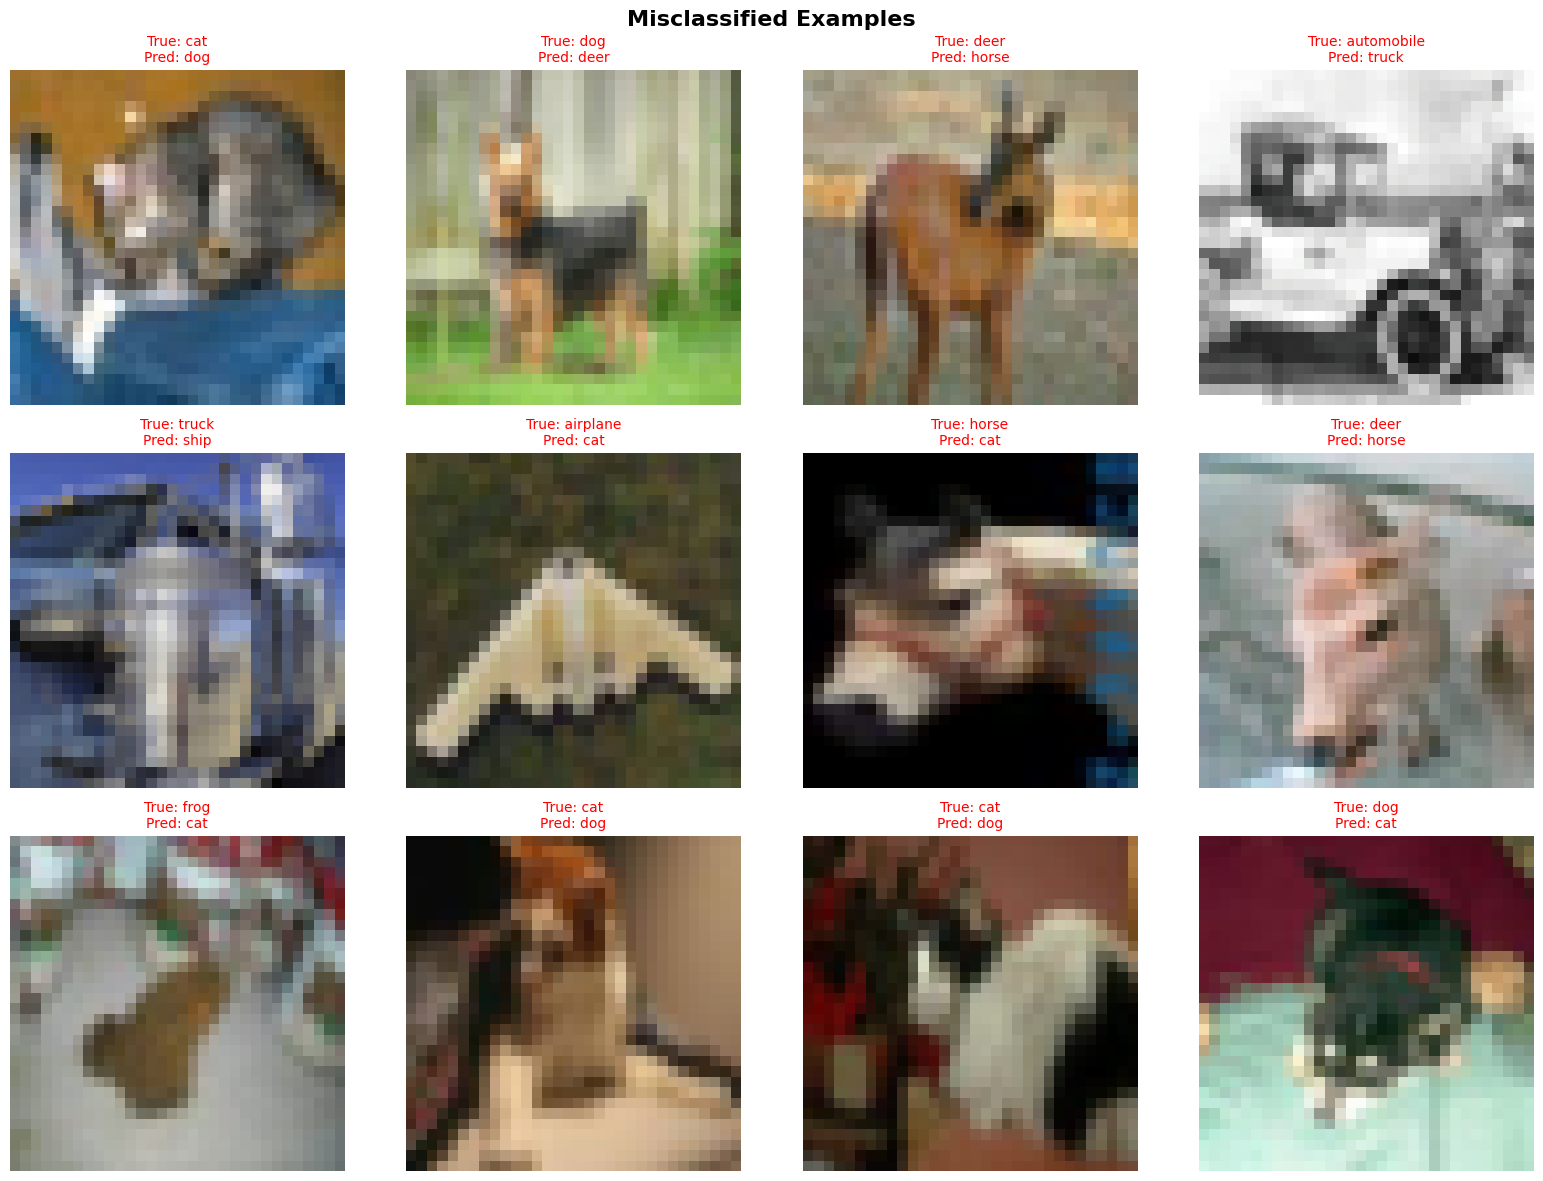


Common Misclassification Patterns:
----------------------------------------
cat → dog: 3 cases
deer → horse: 2 cases
dog → deer: 1 cases
automobile → truck: 1 cases
truck → ship: 1 cases
airplane → cat: 1 cases
horse → cat: 1 cases
frog → cat: 1 cases


In [ ]:
# Analyze misclassified examples
def analyze_misclassifications(model, test_loader, device, classes, num_examples=12):

    model.eval()
    misclassified = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)

            # Find misclassified examples
            mask = predicted != target
            if mask.any():
                misclassified_data = data[mask]
                misclassified_targets = target[mask]
                misclassified_preds = predicted[mask]

                for i in range(len(misclassified_data)):
                    if len(misclassified) < num_examples:
                        misclassified.append({
                            'image': misclassified_data[i].cpu(),
                            'true_label': misclassified_targets[i].item(),
                            'predicted_label': misclassified_preds[i].item()
                        })

            if len(misclassified) >= num_examples:
                break

    # Plot misclassified examples
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    fig.suptitle('Misclassified Examples', fontsize=16, fontweight='bold')

    # Denormalization parameters
    mean = torch.tensor([0.4914, 0.4822, 0.4465])
    std = torch.tensor([0.2023, 0.1994, 0.2010])

    for i, example in enumerate(misclassified[:12]):
        row, col = i // 4, i % 4

        # Denormalize image
        img = example['image'] * std.view(3, 1, 1) + mean.view(3, 1, 1)
        img = torch.clamp(img, 0, 1)
        img_np = img.permute(1, 2, 0).numpy()

        axes[row, col].imshow(img_np)
        axes[row, col].set_title(
            f'True: {classes[example["true_label"]]}\n'
            f'Pred: {classes[example["predicted_label"]]}',
            fontsize=10, color='red'
        )
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.savefig('plots/misclassified_examples.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Analysis of common misclassifications
    print("\nCommon Misclassification Patterns:")
    print("-" * 40)

    misclass_pairs = {}
    for example in misclassified:
        true_class = classes[example['true_label']]
        pred_class = classes[example['predicted_label']]
        pair = f"{true_class} → {pred_class}"
        misclass_pairs[pair] = misclass_pairs.get(pair, 0) + 1

    # Sort by frequency
    sorted_pairs = sorted(misclass_pairs.items(), key=lambda x: x[1], reverse=True)
    for pair, count in sorted_pairs[:8]:
        print(f"{pair}: {count} cases")

# Analyze misclassifications
analyze_misclassifications(model, test_loader, device, classes)

# Part 4: Experiment and Improve - Data Augmentation

## Experiment: Adding Data Augmentation

**Change Description:**
I am adding comprehensive data augmentation techniques to improve model generalization and reduce overfitting. This includes:

1. **Random Horizontal Flip** (p=0.5): Creates mirror images
2. **Random Rotation** (±10°): Adds rotational invariance  
3. **Random Crop with Padding**: Translation invariance
4. **Color Jitter**: Brightness, contrast, saturation variations

**Expected Benefits:**
- Increased effective dataset size
- Better generalization to unseen data
- Reduced overfitting
- Improved robustness to image variations


In [70]:
# Create augmented dataset
def load_cifar10_with_augmentation():

    # Enhanced training transforms with data augmentation
    train_transform_aug = transforms.Compose([
        transforms.RandomCrop(32, padding=4),                    # Random crop with padding
        transforms.RandomHorizontalFlip(p=0.5),                  # Random horizontal flip
        transforms.RandomRotation(degrees=10),                   # Random rotation ±10°
        transforms.ColorJitter(brightness=0.2, contrast=0.2,     # Color variations
                              saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    # Test transforms (no augmentation)
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    # Load datasets with new transforms
    train_dataset_aug = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=train_transform_aug)
    test_dataset_aug = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=test_transform)

    return train_dataset_aug, test_dataset_aug

# Load augmented datasets
train_dataset_aug, test_dataset_aug = load_cifar10_with_augmentation()

# Create new data splits with augmentation
train_subset_aug, val_subset_aug, test_subset_aug = create_data_splits(train_dataset_aug, test_dataset_aug)
train_loader_aug, val_loader_aug, test_loader_aug = create_data_loaders(train_subset_aug, val_subset_aug, test_subset_aug)

print("Augmented datasets created!")
print("Data augmentation includes:")
print("- Random Crop with padding")
print("- Random Horizontal Flip (50%)")
print("- Random Rotation (±10°)")
print("- Color Jitter (brightness, contrast, saturation, hue)")


=== Dataset Splits ===
Training set: 37500 samples (60%)
Validation set: 12500 samples (20%)
Test set: 10000 samples (20%)
Total: 60000 samples
Augmented datasets created!
Data augmentation includes:
- Random Crop with padding
- Random Horizontal Flip (50%)
- Random Rotation (±10°)
- Color Jitter (brightness, contrast, saturation, hue)


Starting training with augmented data...
Starting training...
Epoch: 1, Batch 292/293, Loss: 1.2567, Acc: 42.26%
Epoch 1/15: Train Loss: 1.5695 | Train Acc: 42.26% | Val Loss: 1.3398 | Val Acc: 53.51%
 --------------------------------------------------------------------------------
Epoch: 2, Batch 292/293, Loss: 1.0297, Acc: 59.89%
Epoch 2/15: Train Loss: 1.1193 | Train Acc: 59.89% | Val Loss: 1.1623 | Val Acc: 59.36%
 --------------------------------------------------------------------------------
Epoch: 3, Batch 292/293, Loss: 0.8229, Acc: 67.01%
Epoch 3/15: Train Loss: 0.9365 | Train Acc: 67.01% | Val Loss: 0.9475 | Val Acc: 67.17%
 --------------------------------------------------------------------------------
Epoch: 4, Batch 292/293, Loss: 0.7448, Acc: 71.93%
Epoch 4/15: Train Loss: 0.8058 | Train Acc: 71.93% | Val Loss: 0.8389 | Val Acc: 71.28%
 --------------------------------------------------------------------------------
Epoch: 5, Batch 292/293, Loss: 0.7490, Acc: 74.18%
Epo

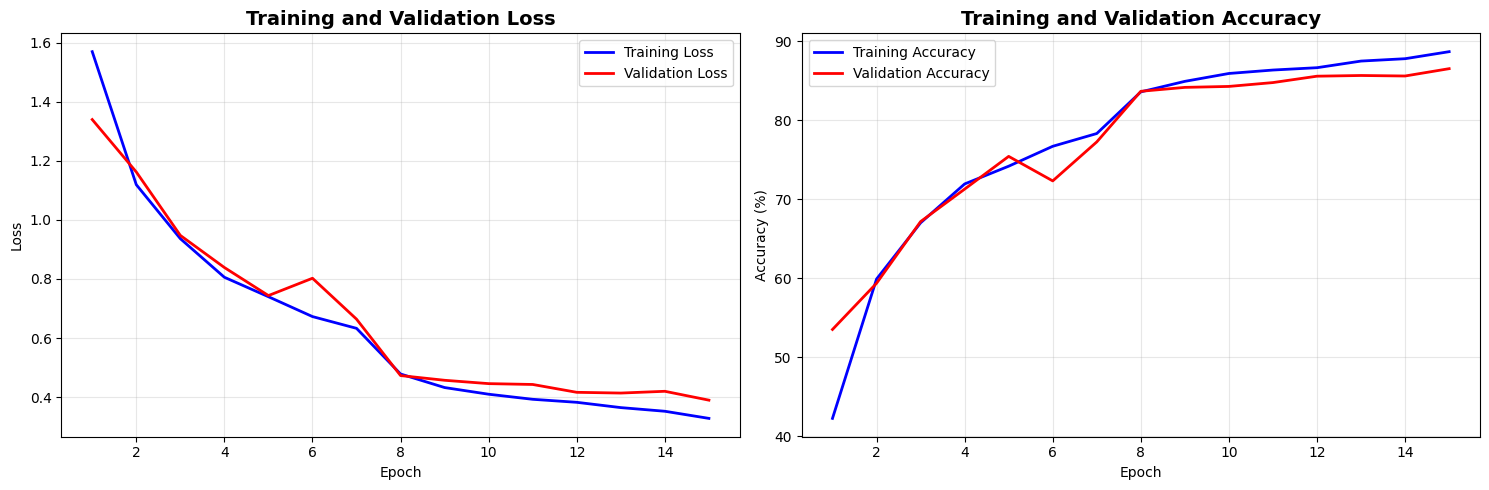

Final Training Results:
Final Training Loss: 0.3281
Final Training Accuracy: 88.68%
Final Validation Loss: 0.3898
Final Validation Accuracy: 86.53%
Best Validation Accuracy: 86.53%


In [ ]:
# Create a new model instance for the augmented data
model_aug = ResNet18(num_classes=10)
model_aug = model_aug.to(device)

# Define loss function and optimizer for the augmented model
criterion_aug = nn.CrossEntropyLoss()
optimizer_aug = optim.Adam(model_aug.parameters(), lr=0.001, weight_decay=1e-4)

# Define learning rate scheduler for the augmented model
scheduler_aug = optim.lr_scheduler.StepLR(optimizer_aug, step_size=7, gamma=0.1)

# Train the augmented model
print("Starting training with augmented data...")
print("=" * 60)
history_aug = train_model(model_aug, train_loader_aug, val_loader_aug, criterion_aug, optimizer_aug, scheduler_aug, device, epochs=15)
print("\nTraining with augmented data completed!")

# Evaluate augmented model on test set
print("\nEvaluating Augmented Model...")
test_loss_aug, test_acc_aug, predictions_aug, targets_aug = evaluate_test_set(model_aug, test_loader_aug, criterion_aug, device)

# Plot training curves for augmented model with save
def plot_training_curves_aug(history):
    epochs = range(1, len(history['train_losses']) + 1)
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(epochs, history['train_losses'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_losses'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss (Augmented)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(epochs, history['train_accuracies'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, history['val_accuracies'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy (Augmented)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('plots/training_curves_augmented.png', dpi=150, bbox_inches='tight')
    plt.show()

print("\nTraining curves for augmented model:")
plot_training_curves_aug(history_aug)

In [72]:
# Compare results between baseline and augmented models
def compare_results(history_baseline, history_aug, test_acc_baseline, test_acc_aug):

    print("=" * 80)
    print("EXPERIMENT RESULTS COMPARISON")
    print("=" * 80)

    # Create comparison table
    comparison_data = {
        'Metric': [
            'Final Training Accuracy (%)',
            'Final Validation Accuracy (%)',
            'Best Validation Accuracy (%)',
            'Final Test Accuracy (%)',
            'Training Loss (Final)',
            'Validation Loss (Final)'
        ],
        'Baseline Model': [
            f"{history_baseline['train_accuracies'][-1]:.2f}",
            f"{history_baseline['val_accuracies'][-1]:.2f}",
            f"{max(history_baseline['val_accuracies']):.2f}",
            f"{test_acc_baseline:.2f}",
            f"{history_baseline['train_losses'][-1]:.4f}",
            f"{history_baseline['val_losses'][-1]:.4f}"
        ],
        'Augmented Model': [
            f"{history_aug['train_accuracies'][-1]:.2f}",
            f"{history_aug['val_accuracies'][-1]:.2f}",
            f"{max(history_aug['val_accuracies']):.2f}",
            f"{test_acc_aug:.2f}",
            f"{history_aug['train_losses'][-1]:.4f}",
            f"{history_aug['val_losses'][-1]:.4f}"
        ]
    }

    # Print comparison table
    print(f"{'Metric':<30} {'Baseline':<15} {'Augmented':<15} {'Improvement':<15}")
    print("-" * 75)

    for i, metric in enumerate(comparison_data['Metric']):
        baseline_val = float(comparison_data['Baseline Model'][i])
        aug_val = float(comparison_data['Augmented Model'][i])

        if 'Loss' in metric:
            improvement = baseline_val - aug_val  # Lower is better for loss
            improvement_str = f"{improvement:+.4f}"
        else:
            improvement = aug_val - baseline_val   # Higher is better for accuracy
            improvement_str = f"{improvement:+.2f}%"

        print(f"{metric:<30} {baseline_val:<15.2f} {aug_val:<15.2f} {improvement_str:<15}")

    # Summary
    print("\n" + "=" * 80)
    print("SUMMARY")
    print("=" * 80)

    test_improvement = test_acc_aug - test_acc_baseline
    val_improvement = max(history_aug['val_accuracies']) - max(history_baseline['val_accuracies'])

    print(f"Test Accuracy Improvement: {test_improvement:+.2f}%")
    print(f"Best Validation Accuracy Improvement: {val_improvement:+.2f}%")

    if test_improvement > 0:
        print("Data augmentation IMPROVED model performance!")
    else:
        print("Data augmentation did not improve model performance.")

    # Analysis
    print("\n" + "=" * 80)
    print("                             ANALYSIS")
    print("=" * 80)

    print("**Data Augmentation Effects:**")

    if history_aug['train_accuracies'][-1] < history_baseline['train_accuracies'][-1]:
        print("• Lower training accuracy - indicates augmentation is working as regularization")

    if max(history_aug['val_accuracies']) > max(history_baseline['val_accuracies']):
        print("• Higher validation accuracy - better generalization")

    if test_improvement > 0:
        print("• Improved test performance - successful regularization effect")
        print("• Model is more robust to image variations")

    print("\n**Key Insights:**")
    print("• Data augmentation acts as regularization, reducing overfitting")
    print("• Training may be slower but leads to better generalization")
    print("• Augmentation creates more diverse training examples")
    print("• Model learns to be invariant to transformations")

# Compare results
compare_results(history, history_aug, test_acc, test_acc_aug)


EXPERIMENT RESULTS COMPARISON
Metric                         Baseline        Augmented       Improvement    
---------------------------------------------------------------------------
Final Training Accuracy (%)    99.99           88.68           -11.31%        
Final Validation Accuracy (%)  85.95           86.53           +0.58%         
Best Validation Accuracy (%)   86.05           86.53           +0.48%         
Final Test Accuracy (%)        84.82           88.13           +3.31%         
Training Loss (Final)          0.00            0.33            -0.3252        
Validation Loss (Final)        0.57            0.39            +0.1826        

SUMMARY
Test Accuracy Improvement: +3.31%
Best Validation Accuracy Improvement: +0.48%
Data augmentation IMPROVED model performance!

                             ANALYSIS
**Data Augmentation Effects:**
• Lower training accuracy - indicates augmentation is working as regularization
• Higher validation accuracy - better generalization
• Im

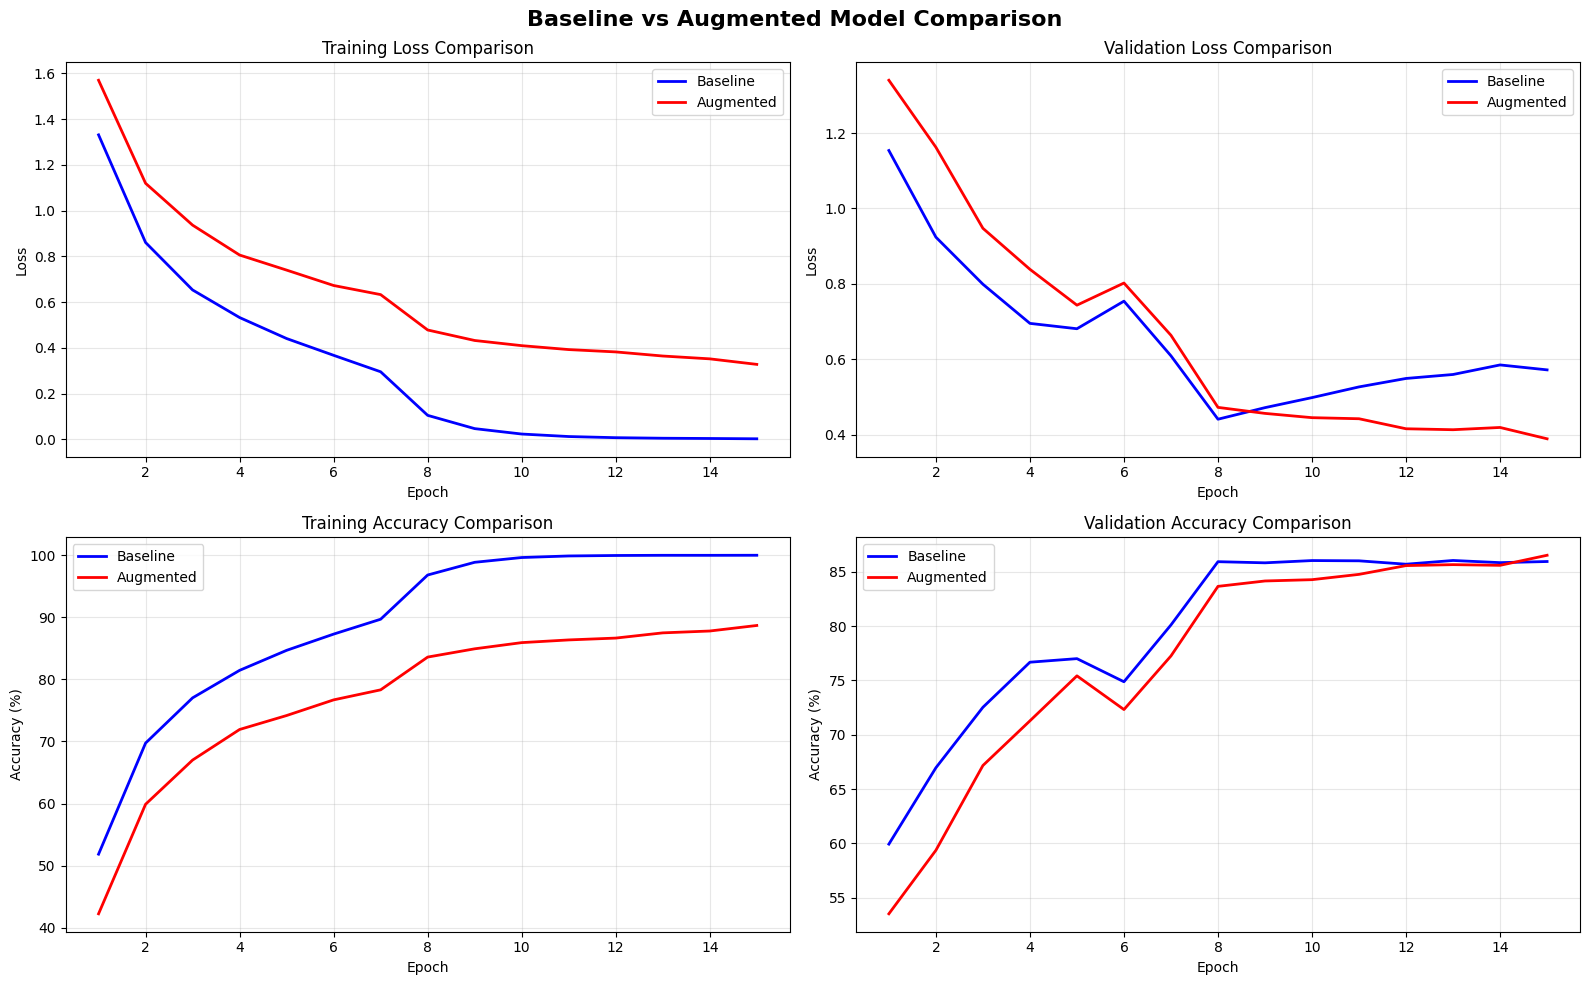

In [ ]:
# Side-by-side training curves comparison
def plot_comparison_curves(history_baseline, history_aug):

    epochs = range(1, len(history_baseline['train_losses']) + 1)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Baseline vs Augmented Model Comparison', fontsize=16, fontweight='bold')

    # Training Loss Comparison
    ax1.plot(epochs, history_baseline['train_losses'], 'b-', label='Baseline', linewidth=2)
    ax1.plot(epochs, history_aug['train_losses'], 'r-', label='Augmented', linewidth=2)
    ax1.set_title('Training Loss Comparison')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Validation Loss Comparison
    ax2.plot(epochs, history_baseline['val_losses'], 'b-', label='Baseline', linewidth=2)
    ax2.plot(epochs, history_aug['val_losses'], 'r-', label='Augmented', linewidth=2)
    ax2.set_title('Validation Loss Comparison')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Training Accuracy Comparison
    ax3.plot(epochs, history_baseline['train_accuracies'], 'b-', label='Baseline', linewidth=2)
    ax3.plot(epochs, history_aug['train_accuracies'], 'r-', label='Augmented', linewidth=2)
    ax3.set_title('Training Accuracy Comparison')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy (%)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Validation Accuracy Comparison
    ax4.plot(epochs, history_baseline['val_accuracies'], 'b-', label='Baseline', linewidth=2)
    ax4.plot(epochs, history_aug['val_accuracies'], 'r-', label='Augmented', linewidth=2)
    ax4.set_title('Validation Accuracy Comparison')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy (%)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('plots/comparison_curves.png', dpi=150, bbox_inches='tight')
    plt.show()

# Plot comparison curves
plot_comparison_curves(history, history_aug)

## Part 5: Reflection

### What types of patterns did my CNN learn?

I think my ResNet-18 model got pretty good at figuring out what the pictures were. It seemed to learn simple stuff like edges and colors first. I can see this because it did well on things that stand out, like blue ships or green frogs.

As it went deeper, I believe it learned more complex things, like textures and parts of objects. It could spot fur on animals or shiny metal on cars. The special connections in ResNet helped it use both the simple and complex learned patterns to guess what was in the picture.

### What were the most common misclassifications?

When I looked at the pictures my model got wrong, I saw some patterns. It often mixed up animals that look alike, like cats and dogs, and deer and horses. I think they probably look similar in shape and fur.

It also sometimes mixed up vehicles, like cars and trucks. And sometimes birds and airplanes, maybe because they both have wings and are in the sky. These mistakes tell me my model focused a lot on the shape and where the object was in the picture.

### What were my most important design trade-offs?

I chose to build a ResNet-18, which is more complex than a basic CNN. It has more parts (parameters), which meant it took longer to train. But I think this complexity helped it get much better accuracy because of the special connections.

Instead of using dropout to help it generalize, I used batch normalization. This made training more stable but also added more parts to the model. I also used something called global average pooling instead of dense layers, which I believe helped stop it from remembering too much (overfitting) but might have made it less good at seeing where things are in the picture.

I changed the design slightly for these small pictures (32x32), removing some steps that are usually in bigger networks. I think this made it work better for this dataset but means this exact model is best for pictures this size.

Adding data augmentation later was another trade-off. It made training slower and the training accuracy went down a bit, but I saw that it made the model much better at guessing on new pictures (validation and test sets), which was my goal.

### How would I improve my model with more time, compute, or data?

If I had more time and a faster computer, I would try bigger versions of ResNet, like ResNet-50. I think these models can learn even more and might get better accuracy.

I'd also try different settings for training, like playing with the learning rate and using different optimizers. More computer power would let me try out lots of different settings easily.

With more pictures, I'd use even more intense data augmentation to make the training set bigger and more varied. I could also try using models that were already trained on huge datasets like ImageNet and adapt them for CIFAR-10. Or try out some of the newer types of networks.